In [1]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt


In [1]:
!pip install opendatasets --upgrade --quiet
import urllib.request
import opendatasets as od

od.download("https://www.kaggle.com/datasets/marcuszhaojunhong/aps360-skeletonized-yoga-pose")

Skipping, found downloaded files in "./aps360-skeletonized-yoga-pose" (use force=True to force download)


In [ ]:
# Define the path to your dataset
data_dir = '/content/aps360-skeletonized-yoga-pose/content/upload_kaggle/skeletonized'
#careful

# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128
    transforms.ToTensor(),          # Convert images to PyTorch tensors
])

# Load dataset
dataset = datasets.ImageFolder(data_dir, transform=transform)

In [ ]:
# Define the split sizes
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [ ]:
# Define batch size
batch_size = 64

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

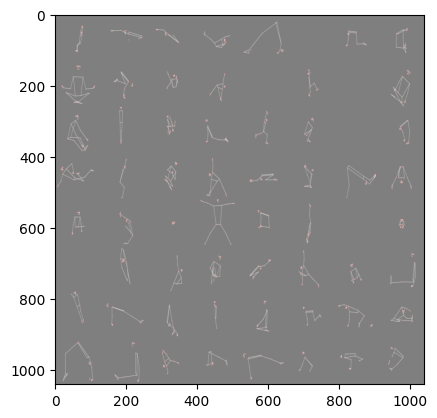

Chair Pose Fish Pose Fish Pose Monkey Pose Two-Legged Inverted Staff Pose Bharadvajas Twist Cat Pose Camel Pose Easy Pose Crane Pose Tortoise Pose Revolved Triangle Pose Mountain Pose High Lunge Lotus Pose Fire Log Pose Standing Half Forward Bend Mountain Pose Crescent Moon Pose Sphinx Pose High Lunge Noose Pose Staff Pose Sunbird Pose Half Frog Pose Chair Pose Easy Pose Extended Triangle Pose Child Pose Heron Pose Half Feather Peacock Pose Wide-Legged Forward Bend Scale Pose Heron Pose Tortoise Pose Extended Side Angle Pose Camel Pose Standing Split Noose Pose Yogic Sleep Pose Sunbird Pose Big Toe Pose Extended Side Angle Pose Half Lord of the Fishes Pose Child Pose Formidable Pose Scale Pose Staff Pose Chair Pose Upward Plank Pose Standing Forward Bend Upward salute Hero Pose Cow Pose Wild Thing Revolved Head to Knee Pose Upward Bow Pose Staff Pose Side Plank Pose Plow Pose Upward Plank Pose Cow Pose Peacock Pose Extended Triangle Pose


In [ ]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))

# Print labels
print(' '.join(f'{dataset.classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, len(dataset.classes))

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 32 * 32)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x



In [ ]:
!nvidia-smi

Thu Aug  1 07:23:29 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P0              31W /  70W |   1693MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
def get_accuracy(model, dataloader):
  "Gets accuracy for final accuracy and accuracy plots"
  correct=0
  total=0
  with torch.no_grad():
    for imgs, labels in dataloader:

      #To Enable GPU Usage
      if use_cuda and torch.cuda.is_available():
          # print("consist")
          imgs = imgs.cuda()
          labels = labels.cuda()

      outputs = model(imgs)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      # print(predicted)#weird size mismatch
      # print(labels)

      correct += (predicted == labels).sum().item()#adds sum of them
  return correct/total

### training with plots


In [ ]:
import time

def train_plot(model, num_epochs):
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)

  iters,losses,train_acc,valid_acc =[],[],[],[]

  start_time=time.time()
  for epoch in range(num_epochs):  # Loop over the dataset multiple times
    running_loss = 0.0
    model.train()  # Set the model to training mode

    for i, data in enumerate(train_loader, 0):
        # Get the inputs; data is a list of [inputs, labels]
        inputs, labels = data


      #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          # model.cuda()
          # print("consist")
          inputs = inputs.cuda()
          labels = labels.cuda()
        #############################################

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 100 == 99:  # Print every 100 mini-batches
            iters.append(epoch * 100 + i)
            losses.append(running_loss / 100)
            train_acc.append(get_accuracy(model, train_loader))
            valid_acc.append(get_accuracy(model, val_loader))

            print(f'Epoch {epoch + 1}, Minibatch {i + 1}, Loss: {running_loss / 100:.3f}')
            print("\tTime Elapsed: % 6.2f s " % (time.time()-start_time))
            running_loss = 0.0

#done training
  print(iters)
  print(losses)

  plt.title("Training Curve")
  plt.plot(iters, losses, label="Train")
  plt.xlabel("Iterations")
  plt.ylabel("Loss")
  plt.show()


  plt.title("Accuracy Train Curve")
  plt.plot(iters, valid_acc, label="Validation")
  plt.plot(iters, train_acc, label="Training")
  plt.legend(loc='best')
  plt.xlabel("Iterations")
  plt.ylabel("Accuracy")
  plt.show()
  print("Final Training Accuracy: {}".format(train_acc[-1]))
  print("Final Validation Accuracy: {}".format(valid_acc[-1]))



CUDA is available!  Training on GPU ...
Epoch 1, Minibatch 100, Loss: 4.073
	Time Elapsed:  124.49 s 
Epoch 1, Minibatch 200, Loss: 3.627
	Time Elapsed:  247.76 s 
[99, 199]
[4.072658672332763, 3.626852774620056]


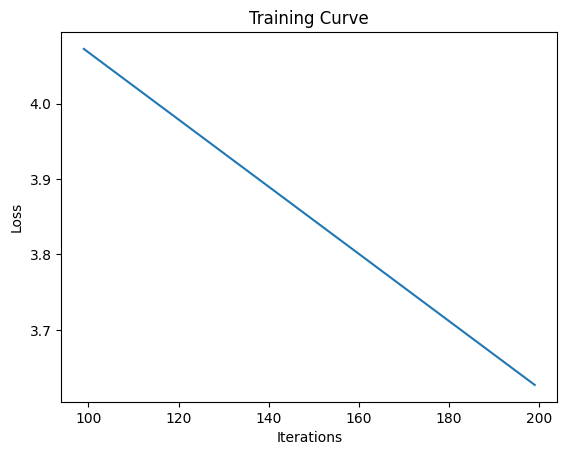

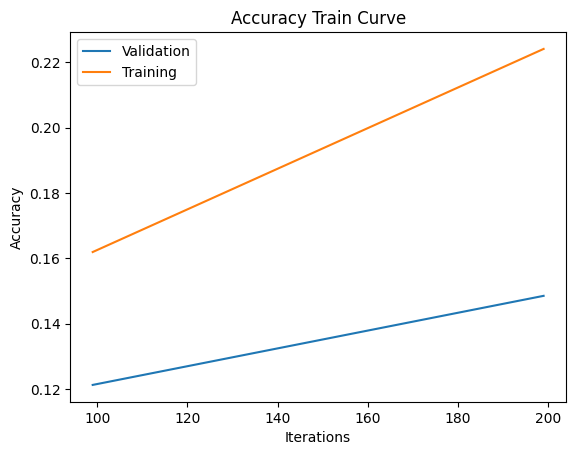

Final Training Accuracy: 0.22411315331669315
Final Validation Accuracy: 0.14853057982525814


In [ ]:
model = SimpleCNN()

use_cuda = True


if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train_plot(model, num_epochs=1)

In [ ]:
test_acc=get_accuracy(model, test_loader)
print(f'Final Test Accuracy: {100 * test_acc:.2f}%')

Final Test Accuracy: 14.50%
